In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

In [2]:
nx = 2
ny = 2
nz = 0

In [3]:
def init(N=100):
    y0 = torch.randn([N,N], requires_grad=True)
    y1 = torch.randn([N,N], requires_grad=True)
    return y0, y1

In [4]:
import torch.nn.functional as F

def laplacian_conv(input_tensor):
    """
    Discrete Laplacian on a grid using convolution and circular padding.
    input_tensor: [N,N]"""

    input_tensor = input_tensor.view(1,1,*input_tensor.shape)

    # Define a 3x3 Laplacian filter for 2D grids
    laplacian_filter = torch.tensor([[0,  1, 0],
                                     [1, -4, 1],
                                     [0,  1, 0]], dtype=torch.float32)

    # Add a channel dimension for compatibility with conv2d
    laplacian_filter = laplacian_filter.view(1, 1, 3, 3)

    # Apply circular padding to the input tensor
    input_tensor_padded = F.pad(input_tensor, (1, 1, 1, 1), mode='circular')

    # Apply 2D convolution with the Laplacian filter
    laplacian_result = F.conv2d(input_tensor_padded, laplacian_filter)

    return laplacian_result.squeeze(1).squeeze(0)

# # Create a 2D grid (e.g., a grayscale image)
# grid = torch.randn((5, 5))  # Assuming a single-channel image with size 256x256

# # Compute the Laplacian using the defined function
# laplacian_result = laplacian_conv(grid)

def gradient_conv(input_tensor):
    input_tensor = input_tensor.view(1,1,*input_tensor.shape)
    # Define Sobel filters for computing partial derivatives
    sobel_x_filter = torch.tensor([[-1, 0, 1],
                                   [-2, 0, 2],
                                   [-1, 0, 1]], dtype=torch.float32)

    sobel_y_filter = torch.tensor([[-1, -2, -1],
                                   [0, 0, 0],
                                   [1, 2, 1]], dtype=torch.float32)

    # Add a channel dimension for compatibility with conv2d
    sobel_x_filter = sobel_x_filter.view(1, 1, 3, 3)
    sobel_y_filter = sobel_y_filter.view(1, 1, 3, 3)

    # Apply circular padding to the input tensor
    input_tensor_padded = F.pad(input_tensor, (1, 1, 1, 1), mode='circular')

    # Apply 2D convolution with Sobel filters for x and y directions
    gradient_x = F.conv2d(input_tensor_padded, sobel_x_filter)
    gradient_y = F.conv2d(input_tensor_padded, sobel_y_filter)

    return gradient_x.squeeze(1).squeeze(0), gradient_y.squeeze(1).squeeze(0)

# # Create a 2D grid (e.g., a grayscale image)
# grid = torch.randn((256, 256))  # Assuming a single-channel image with size 256x256

# # Compute the partial derivatives using the defined function
# gradient_x, gradient_y = gradient_conv(grid)

1.50e-06, -1.00e+00: 100%|██████████| 2000/2000 [00:10<00:00, 193.24it/s]


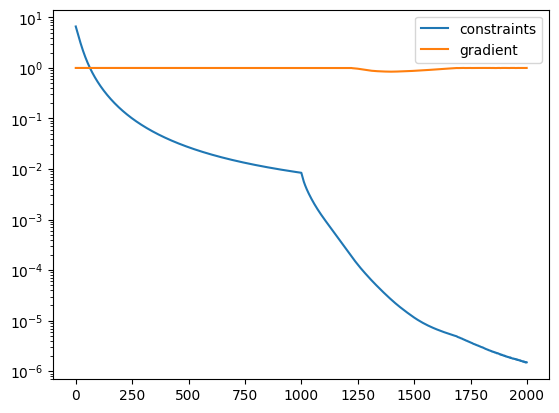

In [32]:
N = 64 ## number of pixels
y0, y1 = init(N=N)

## Optimizer
opt = torch.optim.Adam([y0, y1], lr=1e-1)


D1, D2 = .1, .05
Fr, Kr = 0.028, 0.057
# Fr, Kr = 0.0270, 0.0552
# Fr, Kr = .0545, .062
# Fr, Kr = 0.102, 0.055 ## type rho: long patterns

loss_over_iters = {}
loss_over_iters['obj'] = {}
loss_over_iters['grad'] = {}

## Train
for i in (pbar := trange(2000)):
    if i%1000==0: opt = torch.optim.Adam([y0, y1], lr=1e-2)
    opt.zero_grad()
    
    ## OBJECTIVE ##

    y011 = y0*y1*y1 ## reaction rate u*v*v
    y0_lap = laplacian_conv(y0)
    y1_lap = laplacian_conv(y1)

    res1_field = -y011 + Fr*(1-y0)  + D1*y0_lap
    res2_field =  y011 - (Fr+Kr)*y1 + D2*y1_lap
    loss_obj = (res1_field.square() + res2_field.square()).mean()

    ## GRADIENT NORM ##
    ## Don't allow constant solutions, since we want the bifurcations
    y0_x0, y0_x1 = gradient_conv(y0)
    y1_x0, y1_x1 = gradient_conv(y1)
    y0_grad_norm = (y0_x0.square() + y0_x1.square()).mean()
    y1_grad_norm = (y1_x0.square() + y1_x1.square()).mean()
    loss_grad = -torch.clip((y0_grad_norm+y1_grad_norm), max=1)
    # loss_grad = -torch.clip( (y0.max() - y0.min()).square() + (y1.max() - y1.min()).square(), max=1)

    ## DIVERSITY ##
    # loss_div = loss_diversity(y)
    loss_div = torch.zeros([])
    
    ## OPTIMIZE ##
    loss = loss_obj + loss_div + 1e-5*loss_grad
    loss.backward()
    opt.step()

    ## LOG ##
    pbar.set_description(f"{loss_obj.item():.2e}, {loss_grad.item():.2e}")
    loss_over_iters['obj'][i] =  loss_obj.item()
    loss_over_iters['grad'][i] = -loss_grad.item()


plt.plot(list(loss_over_iters['obj'].keys()), list(loss_over_iters['obj'].values()), label='constraints')
plt.plot(list(loss_over_iters['grad'].keys()), list(loss_over_iters['grad'].values()), label='gradient')
plt.semilogy()
plt.legend()
plt.show()

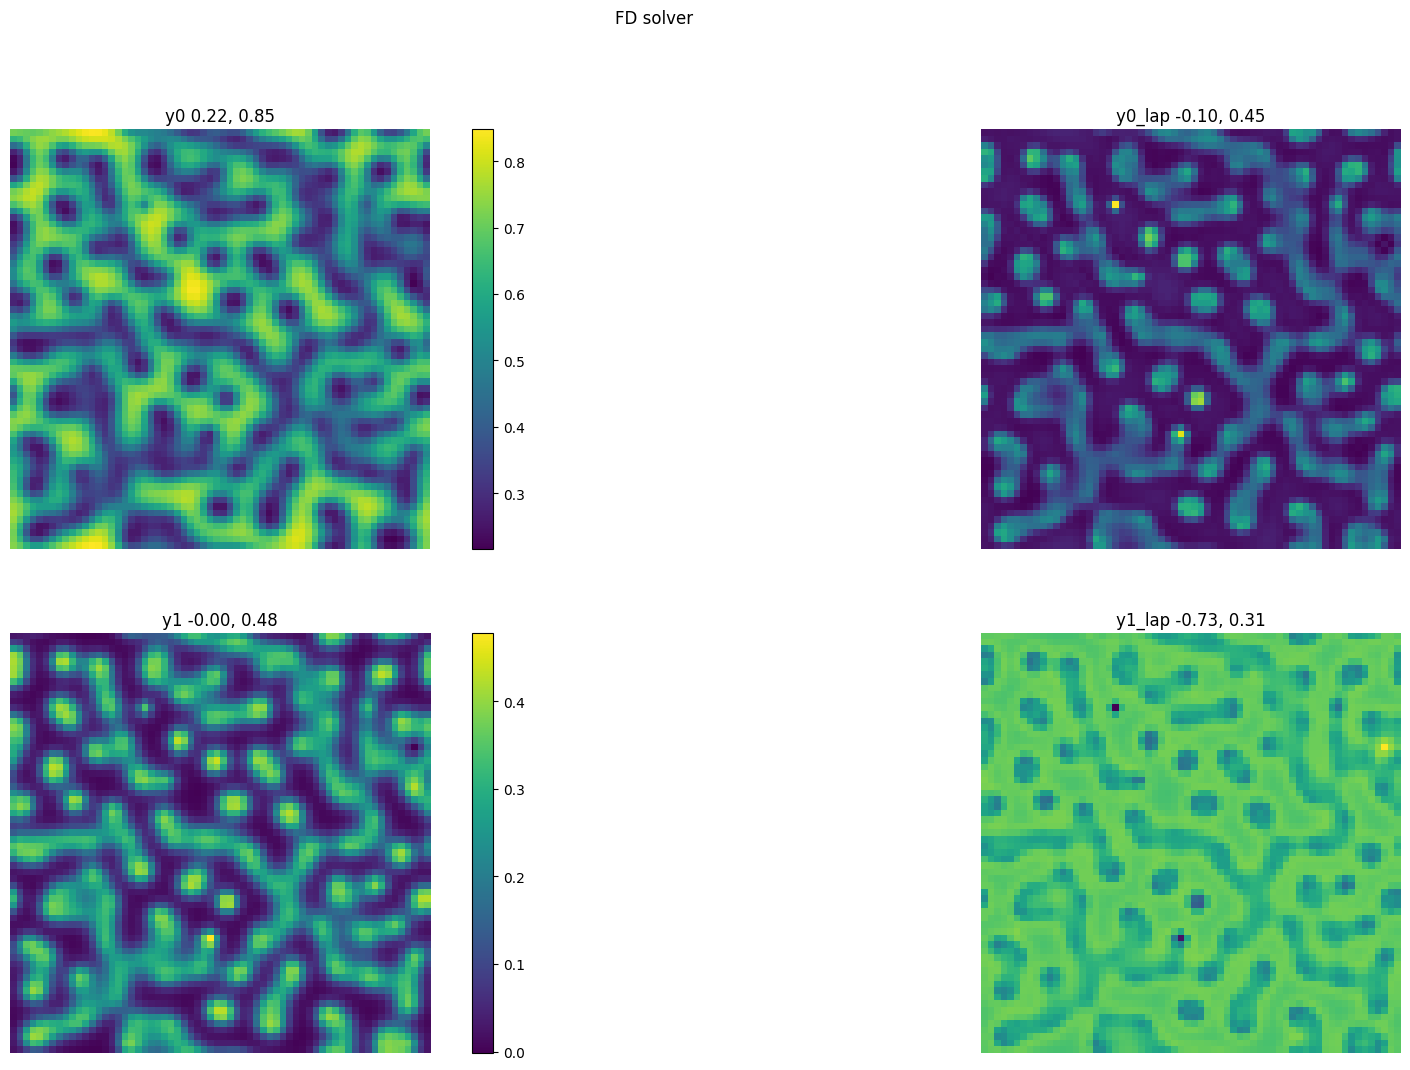

In [33]:
fig, axs = plt.subplots(2, 2, figsize=(24,12))

for iy, Y in enumerate([y0, y1]):
    ax = axs[iy,0]
    im = ax.imshow(Y.detach(), origin='lower')
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy} {Y.min():.2f}, {Y.max():.2f}')
    plt.colorbar(im, ax=ax)


    ax = axs[iy,1]
    Y_lap = laplacian_conv(Y).detach()
    im = ax.imshow(Y_lap, origin='lower')
    ax.axis('scaled')
    ax.axis('off')
    ax.set_title(f'y{iy}_lap {Y_lap.min():.2f}, {Y_lap.max():.2f}')

fig.suptitle('FD solver')
plt.show()